In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pw = pd.read_excel('AllStoresSummaryML_geocodio.xlsx')
pw = pw.reset_index(drop=True)
pw.head()

,Property Name,Project Type,Most Recent Update,Distance to Nearest StorQuest,Address,Jurisdiction,Zoning,Current Use,Land Size (Sq. Ft.),Land Size (Acres),...,Best Comp,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted
0,TX-Plano-CubeSmart Self Storage,Acquisitions,2018-03-07,SQ Dallas Denton 15 Mi SW,"1960 Alma Dr, Plano, TX 75075",NaN,NaN,Self Storage,129204.0,2.96,...,NaN,13.52,93299.0,1.0,70000.0,15.00,7.55,33.025587,-96.715070,-1
1,CA-Riverbank-Trojan Storage,Acquisitions,2018-03-06,StorQuest Modesto 4mi S,"2754 Sierra St, Riverbank, CA 95367",NaN,NaN,Self Storage,45396.0,1.04,...,NaN,9.47,24430.0,0.0,0.0,10.27,5.36,37.733915,-120.946093,-1
2,FL-Riverview-Extra Space Storage,Acquisitions,2018-03-06,StorQuest Tampa / Causeway 3.5 NW,"7018 US-301, Riverview, FL 33578",NaN,NaN,Self Storage,312971.0,7.17,...,NaN,4.63,72660.0,1.0,70000.0,6.33,7.00,27.878458,-82.325649,-1
3,FL-Riverview-CubeSmart Self Storage,Acquisitions,2018-03-06,StorQuest Tampa / Causeway 6.3 NW,"11567 US-301, Riverview, FL 33578",NaN,NaN,Self Storage,122220.0,2.80,...,NaN,5.45,77840.0,0.0,0.0,6.76,7.00,27.832923,-82.329840,-1
4,CO-Frederick-Centennial Self Storage,Acquisitions,2018-03-06,SQ Lafayette 12.2 Mi SW,"9051 Bruin Blvd, Frederick, CO 80504",NaN,NaN,Self Storage,198171.0,4.54,...,NaN,8.77,76044.0,0.0,0.0,10.71,9.14,40.134562,-104.978552,-1


The Vehicles Per Day in Front of Site needs to be made machine readable. We'll use regex and lambda expressions to do this.

In [2]:
pw['Vehicles Per Day in Front of Site'] = pw['Vehicles Per Day in Front of Site'].astype(str)
pw['Vehicles'] = pw['Vehicles Per Day in Front of Site'].str.findall(r'([\d]*,[\d]{3}|^[\d]+$)')
pw['Vehicles'] = [' '.join(a).replace(',','') for a in pw['Vehicles']]
pw['Vehicles'] = pw['Vehicles'].apply(lambda x:x.split(' '))
pw['Vehicles'] = pw['Vehicles'].apply(lambda x:[0] if x==[''] else x)
pw['Vehicles'] = [[int(b) for b in a] for a in pw['Vehicles']]
pw['Vehicles'] = pw['Vehicles'].apply(sum)
pw['Vehicles'] = pw['Vehicles'].replace(0,np.nan)
pw.Vehicles.head()

0    49776.0
1    45000.0
2    39000.0
3    31000.0
4    91000.0
Name: Vehicles, dtype: float64

All of the non-numeric data will be omitted for this project, but we can see some interesting features of the non-numeric data before we remove it.

In [3]:
pw['Project Type'].value_counts()

Development                107
Acquisition                 79
Conversion                  17
SQX development              5
SQX Development              5
Acquisitions                 5
Development/Conversion       4
Conversion/Development       3
development                  2
Development                  1
Dev- Mgmt opp                1
Development (Managed)        1
Ground up Development        1
C/O                          1
Development / Expansion      1
Development/CO               1
Management                   1
Name: Project Type, dtype: int64

Most of these projects are different types of acquisitions or developments, with only one true management project.

In [4]:
pw['Accepted'].value_counts()

 0    183
 1     43
-1      9
Name: Accepted, dtype: int64

We can see that of this data set it is mostly rejected projects (0's), with approximately 20% accepted (1's) and 9 projects still up in the air (-1's).

Since for the actual project we are only going to be using the numeric data, we will drop the rest of it and the data for projects that are undecided. Additionally we will create two new columns that should ultimately prove useful for the end model. These columns are going to represent the difference between the MSA SF per capita and the existing SF per capita and the SF per capita including planned projects, and knowing the industry this should be a fairly important metric.

In [5]:
df = pw.iloc[:,8:]
df = df.drop(['Best Comp', 'Vehicles Per Day in Front of Site'], axis=1)
df = df[df['Accepted']!=-1]

#Add new columns that diff of MSA SF per capita
df['Diff now'] = df['MSA SF per Capita'] - df['Existing Sq. Ft. Per Capita']
df['Diff later'] = df['MSA SF per Capita'] - df['Sq. Ft./Capita including Planned ']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 6 to 234
Data columns (total 25 columns):
Land Size (Sq. Ft.)                     211 non-null float64
Land Size (Acres)                       211 non-null float64
Asking Price                            118 non-null float64
Asking Price per Sq. ft. - Land         115 non-null float64
Current Population                      225 non-null float64
Population in 5 years                   225 non-null float64
Current Households                      225 non-null float64
5 Yr Population Growth                  225 non-null float64
5 Yr SS Sq. Ft. Demand                  225 non-null float64
Median HH Income (US Avg $54K)          225 non-null float64
Daytime Employees                       225 non-null float64
Existing Comparable Facilities          225 non-null float64
Existing Sq. Ft. in Comp. Facilities    224 non-null float64
Existing Sq. Ft. Per Capita             224 non-null float64
Subject Rentable SF                     2

Looking at the non-null value counts of each column, it is clear that there is not enough price information, so it must be dropped. Although having the pricing data could be helpful, its scarcity shows that it ultimately might end up being a point of data leakage because only projects that are more seriously considered are the ones likely to have pricing information.

In the end when we don't have to worry about the pricing data we will retain much more data also.

In [6]:
len(df) #226
len(df.dropna()) #90
len(df[['Land Size (Sq. Ft.)', 'Land Size (Acres)', 'Current Population',
       'Population in 5 years', 'Current Households', '5 Yr Population Growth',
       '5 Yr SS Sq. Ft. Demand', 'Median HH Income (US Avg $54K)',
       'Daytime Employees', 'Existing Comparable Facilities',
       'Existing Sq. Ft. in Comp. Facilities', 'Existing Sq. Ft. Per Capita',
       'Subject Rentable SF', "Add'l Planned/Proposed Facilities",
       "Add'l Planned/Proposed Facilities SF",
       'Sq. Ft./Capita including Planned ', 'MSA SF per Capita', 'Latitude',
       'Longitude','Accepted','Vehicles',
       'Diff now', 'Diff later']].dropna()) #180 instead of only 92

df = df[['Land Size (Sq. Ft.)', 'Land Size (Acres)', 'Current Population',
       'Population in 5 years', 'Current Households', '5 Yr Population Growth',
       '5 Yr SS Sq. Ft. Demand', 'Median HH Income (US Avg $54K)',
       'Daytime Employees', 'Existing Comparable Facilities',
       'Existing Sq. Ft. in Comp. Facilities', 'Existing Sq. Ft. Per Capita',
       'Subject Rentable SF', "Add'l Planned/Proposed Facilities",
       "Add'l Planned/Proposed Facilities SF",
       'Sq. Ft./Capita including Planned ', 'MSA SF per Capita', 'Latitude',
       'Longitude','Accepted','Vehicles',
       'Diff now', 'Diff later']]

Now that we have our dataset, let's plot each column to get a rough idea of how they are distributed.

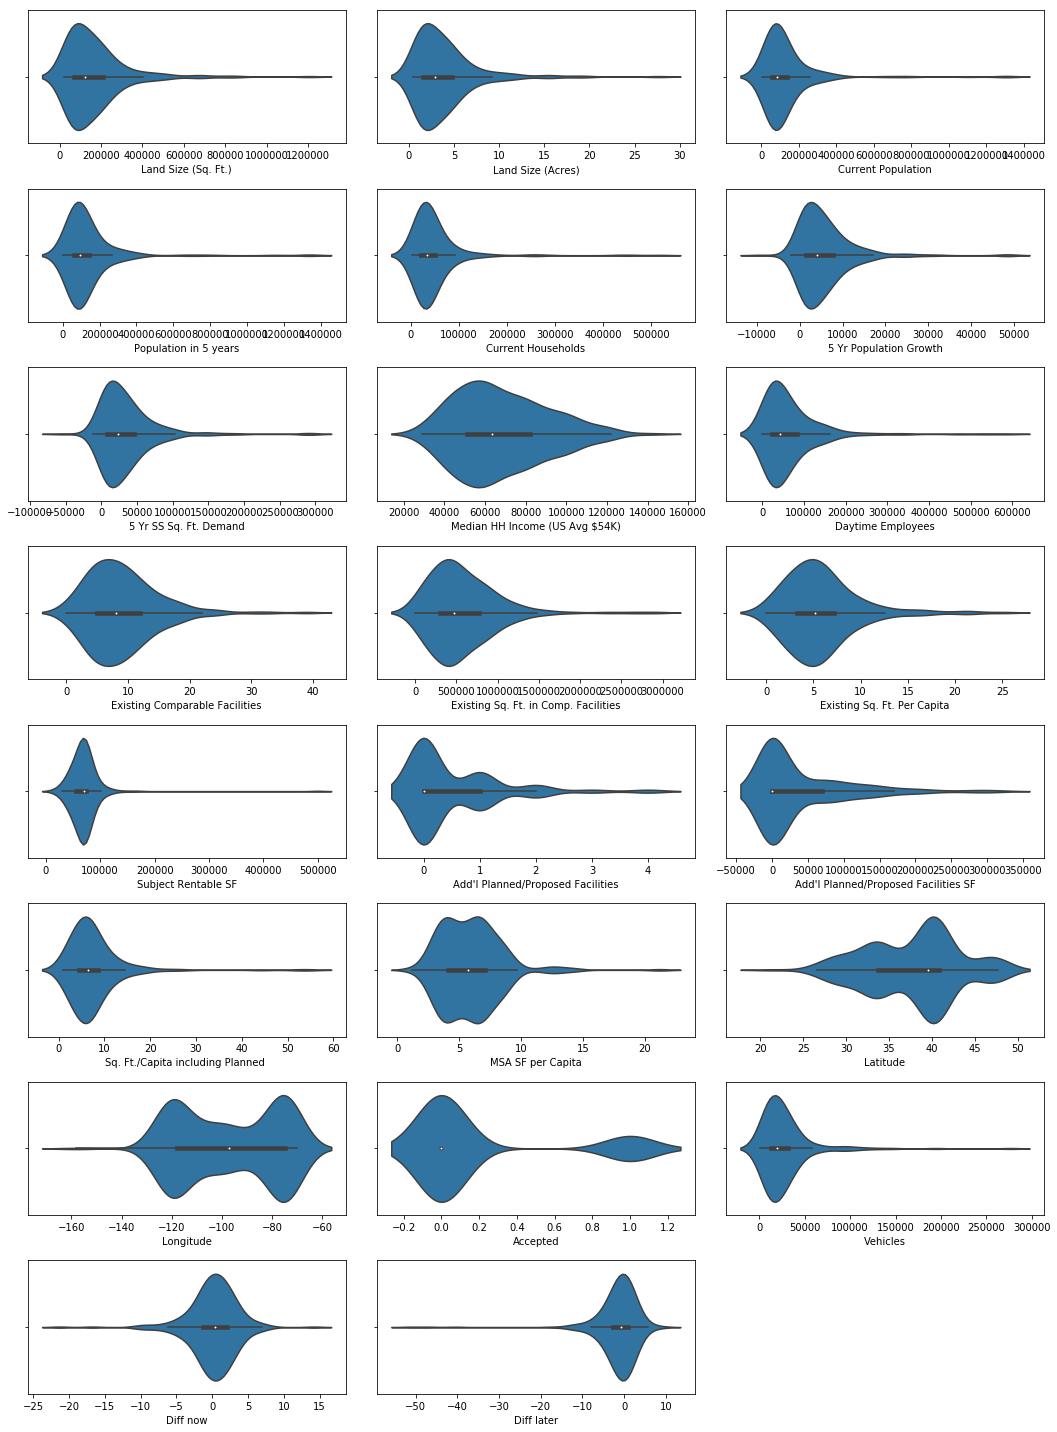

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(15,20))
for c, col in enumerate(df.columns, 1):
    ax = fig.add_subplot(8,3,c)
    sns.violinplot(data=df, x=col)
fig.tight_layout()

Looking at all these distributions, it's not too hard to tell that most of them have long right tails. This makes sense because most of these features have lower limits, but no upper limits, which leads to outliers to the right.

Now let's check how these variables relate to each other.

In [8]:
df.corr()

,Land Size (Sq. Ft.),Land Size (Acres),Current Population,Population in 5 years,Current Households,5 Yr Population Growth,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Existing Comparable Facilities,...,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted,Vehicles,Diff now,Diff later
Land Size (Sq. Ft.),1.000000,0.999999,-0.182511,-0.182296,-0.174304,-0.100959,-0.100938,0.102646,-0.154997,-0.141089,...,-0.059131,-0.054514,0.135516,0.107460,-0.054607,0.086930,-0.176446,0.064672,-0.110981,-0.099398
Land Size (Acres),0.999999,1.000000,-0.182699,-0.182477,-0.174480,-0.100909,-0.100889,0.102687,-0.155164,-0.141203,...,-0.059392,-0.054755,0.135531,0.107697,-0.054734,0.087068,-0.176324,0.064549,-0.110924,-0.099322
Current Population,-0.182511,-0.182699,1.000000,0.999461,0.989457,0.567052,0.567059,-0.248610,0.732891,0.601613,...,0.274184,0.280559,-0.299519,-0.284451,0.112879,0.159221,-0.037383,0.041857,0.135405,0.200220
Population in 5 years,-0.182296,-0.182477,0.999461,1.000000,0.990399,0.593781,0.593787,-0.247323,0.737713,0.607828,...,0.275239,0.281724,-0.298986,-0.278258,0.105767,0.151858,-0.033840,0.040843,0.136762,0.202083
Current Households,-0.174304,-0.174480,0.989457,0.990399,1.000000,0.598107,0.598114,-0.238573,0.772524,0.609132,...,0.283357,0.292528,-0.289302,-0.271829,0.132031,0.170831,-0.049112,0.036193,0.128964,0.194661
5 Yr Population Growth,-0.100959,-0.100909,0.567052,0.593781,0.598107,1.000000,1.000000,-0.111996,0.546494,0.505222,...,0.185417,0.191858,-0.160298,-0.009728,-0.112967,-0.092389,0.067197,-0.001561,0.113259,0.163112
5 Yr SS Sq. Ft. Demand,-0.100938,-0.100889,0.567059,0.593787,0.598114,1.000000,1.000000,-0.112021,0.546508,0.505248,...,0.185440,0.191880,-0.160286,-0.009718,-0.112936,-0.092339,0.067217,-0.001542,0.113245,0.163103
Median HH Income (US Avg $54K),0.102646,0.102687,-0.248610,-0.247323,-0.238573,-0.111996,-0.112021,1.000000,-0.132789,-0.432395,...,-0.034912,0.012619,0.051337,-0.234797,0.105291,0.136580,-0.141001,-0.036944,-0.044471,-0.145888
Daytime Employees,-0.154997,-0.155164,0.732891,0.737713,0.772524,0.546494,0.546508,-0.132789,1.000000,0.531754,...,0.227626,0.236334,-0.262845,-0.277547,0.143136,0.132686,0.011943,0.057462,0.081954,0.162952
Existing Comparable Facilities,-0.141089,-0.141203,0.601613,0.607828,0.609132,0.505222,0.505248,-0.432395,0.531754,1.000000,...,0.230518,0.192484,-0.018528,0.054627,0.009555,-0.194140,-0.000827,0.057415,-0.183449,0.040919


This correlation matrix is too large and cluttered so let's break it down into easier to manage pieces.

### Land Size

In [9]:
df[['Land Size (Sq. Ft.)', 'Land Size (Acres)', 'Subject Rentable SF']].corr()

,Land Size (Sq. Ft.),Land Size (Acres),Subject Rentable SF
Land Size (Sq. Ft.),1.000000,0.999999,0.299119
Land Size (Acres),0.999999,1.000000,0.298851
Subject Rentable SF,0.299119,0.298851,1.000000


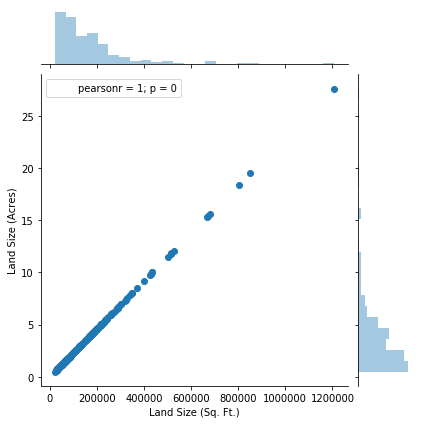

In [10]:
sns.jointplot(data=df, x='Land Size (Sq. Ft.)', y='Land Size (Acres)')

Unsprisingly, land size square footage and acrage correlate nearly perfectly since it is just a formula to go from acres to square feet or vice versa. As a result, we will drop one of these later since they are representing the same thing. Subject rentable SF has a weak positive correlation with land size, which is surprising given that the rentable sqaure feet seems as though it would correlate very strongly to the size of the land it is on. This could be because of multi-story buildings where the rentable SF could be larger than the actual land it is on.

Due to this perfect correlation, we do not need both land size variables. Thus we will drop Land Size (Sq. Ft.). 

In [11]:
df = df.drop('Land Size (Sq. Ft.)', axis=1)

### Demographics

In [12]:
df[['Current Population',
       'Population in 5 years', 'Current Households', '5 Yr Population Growth',
       '5 Yr SS Sq. Ft. Demand', 'Median HH Income (US Avg $54K)',
       'Daytime Employees', 'Vehicles', 'Longitude','Latitude']].corr()

,Current Population,Population in 5 years,Current Households,5 Yr Population Growth,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Vehicles,Longitude,Latitude
Current Population,1.000000,0.999461,0.989457,0.567052,0.567059,-0.248610,0.732891,0.041857,0.159221,0.112879
Population in 5 years,0.999461,1.000000,0.990399,0.593781,0.593787,-0.247323,0.737713,0.040843,0.151858,0.105767
Current Households,0.989457,0.990399,1.000000,0.598107,0.598114,-0.238573,0.772524,0.036193,0.170831,0.132031
5 Yr Population Growth,0.567052,0.593781,0.598107,1.000000,1.000000,-0.111996,0.546494,-0.001561,-0.092389,-0.112967
5 Yr SS Sq. Ft. Demand,0.567059,0.593787,0.598114,1.000000,1.000000,-0.112021,0.546508,-0.001542,-0.092339,-0.112936
Median HH Income (US Avg $54K),-0.248610,-0.247323,-0.238573,-0.111996,-0.112021,1.000000,-0.132789,-0.036944,0.136580,0.105291
Daytime Employees,0.732891,0.737713,0.772524,0.546494,0.546508,-0.132789,1.000000,0.057462,0.132686,0.143136
Vehicles,0.041857,0.040843,0.036193,-0.001561,-0.001542,-0.036944,0.057462,1.000000,-0.051445,-0.046340
Longitude,0.159221,0.151858,0.170831,-0.092389,-0.092339,0.136580,0.132686,-0.051445,1.000000,-0.022380
Latitude,0.112879,0.105767,0.132031,-0.112967,-0.112936,0.105291,0.143136,-0.046340,-0.022380,1.000000


Current population, population in 5 years, and current households all have strong correlation as expected and some positive correlation with 5 year population growth and 5 year SF demand. It looks like 5 year population and 5 year SF demand are perfectly correlated, which is unsurprising because it is a formulaic calculation. Interestingly median HH income has a slight negative correlation to all of the population variables. More population tends to mean a lower median income as well. Daytime employees has a fairly strong positive correlation to population as expected. More people should mean more jobs. There is no strong relationship between vehicles and anything.

To avoid repetitive data, 5 Yr Population Growth, Population in 5 years, Current Households will be dropped since they have greater than .99 correlation with other variables.

Let's graph of some of these relationships to get a visual of the correlations we are seeing.

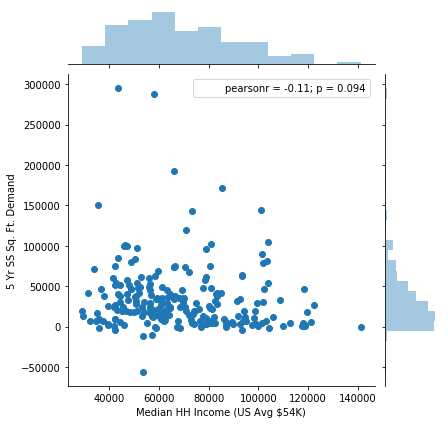

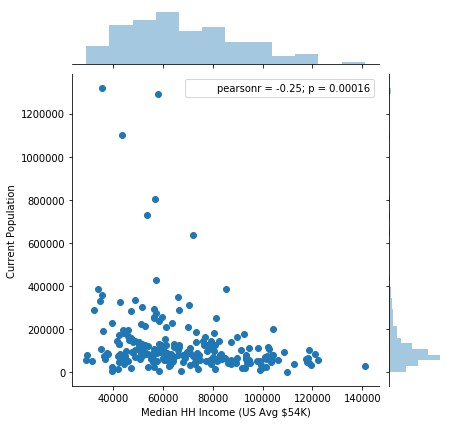

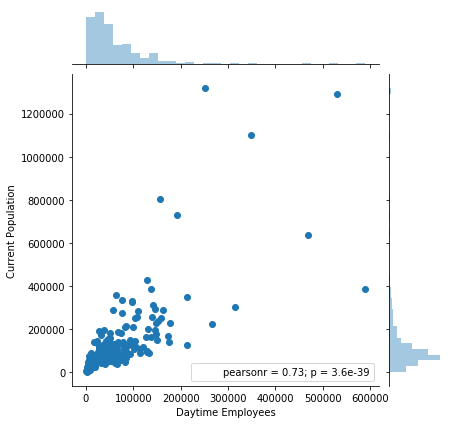

In [13]:
df = df.drop(['5 Yr Population Growth','Population in 5 years','Current Households'], axis=1)

sns.jointplot(data=df, x='Median HH Income (US Avg $54K)', y='5 Yr SS Sq. Ft. Demand')
sns.jointplot(data=df, x='Median HH Income (US Avg $54K)', y='Current Population')
sns.jointplot(data=df, x='Daytime Employees', y='Current Population')

### Self Storage Market

In [14]:
df[['Existing Comparable Facilities',
       'Existing Sq. Ft. in Comp. Facilities', 'Existing Sq. Ft. Per Capita',
       'Subject Rentable SF', "Add'l Planned/Proposed Facilities",
       "Add'l Planned/Proposed Facilities SF",
       'Sq. Ft./Capita including Planned ', 'MSA SF per Capita', 'Accepted',
       'Diff now', 'Diff later']].corr()

,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Accepted,Diff now,Diff later
Existing Comparable Facilities,1.000000,0.903503,0.197980,0.086066,0.230518,0.192484,-0.018528,0.054627,-0.000827,-0.183449,0.040919
Existing Sq. Ft. in Comp. Facilities,0.903503,1.000000,0.251803,0.092715,0.236004,0.197039,0.018533,-0.003633,-0.013055,-0.282393,-0.020646
Existing Sq. Ft. Per Capita,0.197980,0.251803,1.000000,-0.114692,-0.020442,-0.078489,0.752218,0.467472,-0.029767,-0.792893,-0.599284
Subject Rentable SF,0.086066,0.092715,-0.114692,1.000000,0.094335,0.143019,-0.036384,-0.108061,-0.050847,0.054304,-0.004092
Add'l Planned/Proposed Facilities,0.230518,0.236004,-0.020442,0.094335,1.000000,0.943231,0.012275,-0.005889,-0.033278,0.017374,-0.015113
Add'l Planned/Proposed Facilities SF,0.192484,0.197039,-0.078489,0.143019,0.943231,1.000000,-0.019278,-0.033989,-0.068149,0.062704,0.006712
Sq. Ft./Capita including Planned,-0.018528,0.018533,0.752218,-0.036384,0.012275,-0.019278,1.000000,0.293963,0.010062,-0.637553,-0.926699
MSA SF per Capita,0.054627,-0.003633,0.467472,-0.108061,-0.005889,-0.033989,0.293963,1.000000,0.017355,0.168024,0.086786
Accepted,-0.000827,-0.013055,-0.029767,-0.050847,-0.033278,-0.068149,0.010062,0.017355,1.000000,0.044585,-0.003473
Diff now,-0.183449,-0.282393,-0.792893,0.054304,0.017374,0.062704,-0.637553,0.168024,0.044585,1.000000,0.730068


There is a strong positive correlation between existing comparable facilities and existing SF in comparable facilities. Existing SF per capita and SF per capita including planned have a strong positive correlation. Existing SF per capita and diff now, diff later have a strong negative correlation. Subject rentable SF, MSA SF/ capita, and Accepted do not have a strong relationship with any other column. Additional planned/ proposed facilities and additional facility SF are close as expected. SF per capita including planned has a strong negative correlation to diff later, which makes sense, diff later is derived from SF per capita including planned. Diff now and diff later also have a strong positive correlation as expected.

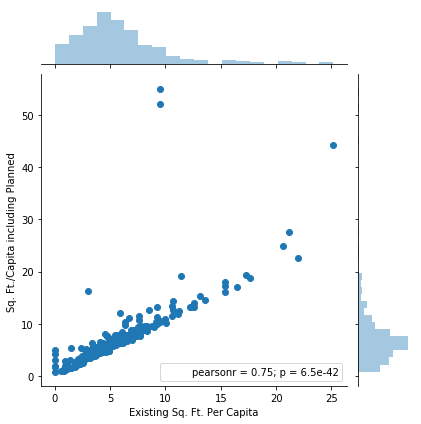

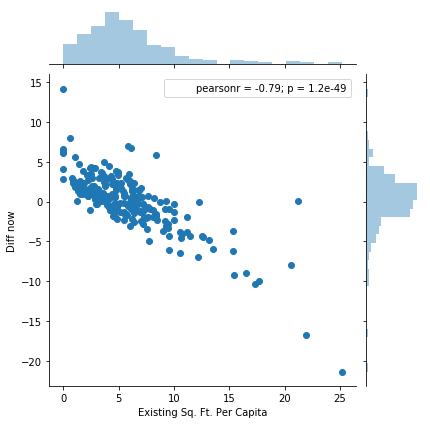

In [15]:
sns.jointplot(data=df, x='Existing Sq. Ft. Per Capita', y='Sq. Ft./Capita including Planned ')
sns.jointplot(data=df, x='Existing Sq. Ft. Per Capita', y='Diff now')

Let's look at the whole picture one more time to see if any other relationships show up. We will use only the land size acres and no population growth this time because of their perfect or near perfect correlation to land size SF and 5 year SS Sq. Ft. Demand respectively.

In [16]:
df.corr()

,Land Size (Acres),Current Population,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted,Vehicles,Diff now,Diff later
Land Size (Acres),1.000000,-0.182699,-0.100889,0.102687,-0.155164,-0.141203,-0.062946,0.164982,0.298851,-0.059392,-0.054755,0.135531,0.107697,-0.054734,0.087068,-0.176324,0.064549,-0.110924,-0.099322
Current Population,-0.182699,1.000000,0.567059,-0.248610,0.732891,0.601613,0.613821,-0.295922,0.193395,0.274184,0.280559,-0.299519,-0.284451,0.112879,0.159221,-0.037383,0.041857,0.135405,0.200220
5 Yr SS Sq. Ft. Demand,-0.100889,0.567059,1.000000,-0.112021,0.546508,0.505248,0.532964,-0.108914,0.086968,0.185440,0.191880,-0.160286,-0.009718,-0.112936,-0.092339,0.067217,-0.001542,0.113245,0.163103
Median HH Income (US Avg $54K),0.102687,-0.248610,-0.112021,1.000000,-0.132789,-0.432395,-0.354015,-0.109504,0.117930,-0.034912,0.012619,0.051337,-0.234797,0.105291,0.136580,-0.141001,-0.036944,-0.044471,-0.145888
Daytime Employees,-0.155164,0.732891,0.546508,-0.132789,1.000000,0.531754,0.525733,-0.245498,0.393275,0.227626,0.236334,-0.262845,-0.277547,0.143136,0.132686,0.011943,0.057462,0.081954,0.162952
Existing Comparable Facilities,-0.141203,0.601613,0.505248,-0.432395,0.531754,1.000000,0.903503,0.197980,0.086066,0.230518,0.192484,-0.018528,0.054627,0.009555,-0.194140,-0.000827,0.057415,-0.183449,0.040919
Existing Sq. Ft. in Comp. Facilities,-0.062946,0.613821,0.532964,-0.354015,0.525733,0.903503,1.000000,0.251803,0.092715,0.236004,0.197039,0.018533,-0.003633,-0.045127,-0.154058,-0.013055,0.068942,-0.282393,-0.020646
Existing Sq. Ft. Per Capita,0.164982,-0.295922,-0.108914,-0.109504,-0.245498,0.197980,0.251803,1.000000,-0.114692,-0.020442,-0.078489,0.752218,0.467472,-0.144333,-0.238351,-0.029767,-0.020655,-0.792893,-0.599284
Subject Rentable SF,0.298851,0.193395,0.086968,0.117930,0.393275,0.086066,0.092715,-0.114692,1.000000,0.094335,0.143019,-0.036384,-0.108061,0.077109,0.126158,-0.050847,0.034459,0.054304,-0.004092
Add'l Planned/Proposed Facilities,-0.059392,0.274184,0.185440,-0.034912,0.227626,0.230518,0.236004,-0.020442,0.094335,1.000000,0.943231,0.012275,-0.005889,0.219962,-0.056009,-0.033278,0.044663,0.017374,-0.015113


Looking at this, the current population, 5 Yr SS Sq. Ft. Demand, and daytime employees have a siginifcant positive correlation to Existing facilities and their SF. Median HH Income and Existing comp facilities have somewhat significant negative correlation.

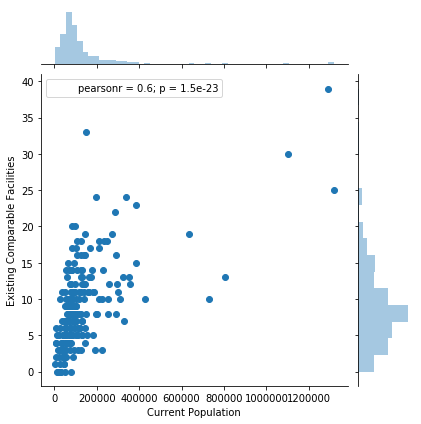

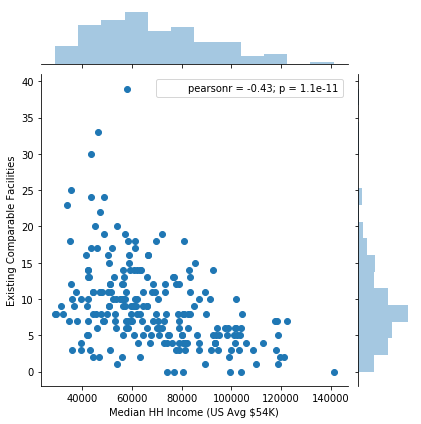

In [17]:
sns.jointplot(data=df, x='Current Population', y='Existing Comparable Facilities')
sns.jointplot(data=df, x='Median HH Income (US Avg $54K)', y='Existing Comparable Facilities')

It looks like most of the remaining missing data is from subject rentable SF and land size info. Let's explore further.

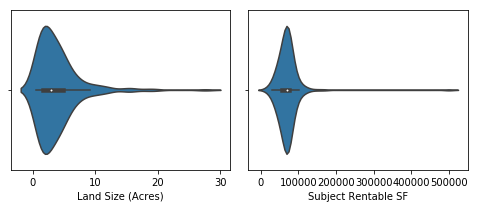

In [18]:
df[['Land Size (Acres)', 'Subject Rentable SF']].describe()

fig = plt.figure(figsize=(10,3))
for c, col in enumerate(['Land Size (Acres)', 'Subject Rentable SF'], 1):
    ax = fig.add_subplot(1,3,c)
    sns.violinplot(data=df, x=col)
fig.tight_layout()

Land size has some variation, but Subject Rentable SF seems to be fairly consistent, we could find the mean and fillna since subject rentable SF has no strong relationship with anything. In the making of the project workbooks if the subject rentable size is unknown the value is filled in with 70000. Therefore using the mean, which is close to 70000, seems to be an acceptable solution.

In [19]:
df1 = df
df = df.dropna()
df1['Subject Rentable SF'].fillna(df1['Subject Rentable SF'].mean(), inplace=True)
print(df.corr()['Subject Rentable SF'] - df1.corr()['Subject Rentable SF'])

Land Size (Acres)                       0.008350
Current Population                     -0.000454
5 Yr SS Sq. Ft. Demand                  0.000366
Median HH Income (US Avg $54K)          0.009639
Daytime Employees                       0.020408
Existing Comparable Facilities          0.005489
Existing Sq. Ft. in Comp. Facilities   -0.001794
Existing Sq. Ft. Per Capita            -0.027266
Subject Rentable SF                     0.000000
Add'l Planned/Proposed Facilities      -0.007722
Add'l Planned/Proposed Facilities SF    0.001989
Sq. Ft./Capita including Planned        0.022917
MSA SF per Capita                      -0.007583
Latitude                               -0.006386
Longitude                               0.008588
Accepted                                0.033266
Vehicles                               -0.000427
Diff now                                0.026768
Diff later                             -0.036331
Name: Subject Rentable SF, dtype: float64


Nothing changed in the correlation of subject rentable SF.

Now let's see the the basic statistical measures of each column.

In [20]:
df1.describe()

,Land Size (Acres),Current Population,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted,Vehicles,Diff now,Diff later
count,211.000000,2.250000e+02,225.000000,225.000000,225.000000,225.000000,2.240000e+02,224.000000,226.000000,223.000000,223.000000,224.000000,226.000000,226.000000,226.000000,226.000000,203.000000,224.000000,224.000000
mean,3.847204,1.322658e+05,33965.706667,68192.937778,65658.346667,8.986667,5.732098e+05,5.837634,70028.101942,0.511211,37820.704036,7.612500,5.895664,37.808457,-97.327971,0.190265,27366.852217,0.062455,-1.720893
std,3.590704,1.674056e+05,40970.967125,22346.833539,77438.901808,5.843556,4.246492e+05,4.010481,34188.981733,0.853509,64987.876969,6.579507,2.471519,5.384071,20.079631,0.393382,30792.678812,3.596427,6.312621
min,0.510000,3.230000e+03,-55596.000000,29080.000000,316.000000,0.000000,0.000000e+00,0.000000,17895.000000,0.000000,0.000000,0.870000,1.200000,21.313415,-158.095274,0.000000,501.000000,-21.350000,-51.560000
25%,1.580000,5.781800e+04,7968.000000,51074.000000,23089.000000,5.000000,3.025225e+05,3.247500,60059.000000,0.000000,0.000000,4.420000,4.100000,33.755318,-118.103793,0.000000,12391.000000,-1.362500,-2.760000
50%,2.860000,8.687500e+04,23802.000000,63563.000000,43641.000000,8.000000,4.749850e+05,5.125000,70000.000000,0.000000,0.000000,6.405000,5.730000,39.541032,-97.140702,0.000000,19796.000000,0.445000,-0.645000
75%,4.750000,1.387290e+05,46050.000000,82000.000000,82308.000000,12.000000,7.807002e+05,7.160000,73118.750000,1.000000,70000.000000,8.552500,7.087500,40.817898,-74.961213,0.000000,31522.000000,2.000000,1.032500
max,27.610000,1.316764e+06,294642.000000,141050.000000,588755.000000,39.000000,2.928500e+06,25.180000,500000.000000,4.000000,315131.000000,55.060000,21.200000,47.767517,-70.058734,1.000000,276313.000000,14.190000,9.250000


Land size, Existing Sq. Ft. Per Capita, Sq. Ft./Capita including Planned, Diff now and later have some clear outliers.

In [21]:
df1[df1['Land Size (Acres)']>15]

,Land Size (Acres),Current Population,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted,Vehicles,Diff now,Diff later
43,15.27,635272.0,68190.0,72138.0,468377.0,19.0,1258457.0,1.98,500000.0,1.0,140000.0,2.99,3.50,40.674133,-74.014043,0,5939.0,1.52,0.51
58,15.56,44467.0,5070.0,89274.0,31737.0,1.0,109501.0,2.46,65701.0,0.0,0.0,3.94,3.79,40.289589,-74.798109,0,68035.0,1.33,-0.15
59,27.61,85957.0,45828.0,63190.0,25087.0,14.0,1888043.0,21.96,58175.0,0.0,0.0,22.64,5.20,36.811182,-119.891739,0,58404.0,-16.76,-17.44
108,18.42,44136.0,702.0,118682.0,20285.0,1.0,64910.0,1.47,168950.0,0.0,0.0,5.30,3.50,40.844499,-73.701201,0,16809.0,2.03,-1.80
168,19.54,86587.0,24594.0,53096.0,43858.0,7.0,611800.0,7.07,70100.0,0.0,0.0,7.88,7.70,39.523671,-119.859492,0,5450.0,0.63,-0.18
191,15.45,84596.0,38388.0,37836.0,25794.0,7.0,474570.0,5.61,89970.0,0.0,0.0,6.67,4.10,37.582946,-77.408184,0,31156.0,-1.51,-2.57


These outliers make sense. They are valid data points, just extreme ones, and will be left in.

In [22]:
df1[df1['Existing Sq. Ft. Per Capita'] >20][['Existing Sq. Ft. Per Capita', 'Current Population', 
                                             'Existing Comparable Facilities', 'Existing Sq. Ft. in Comp. Facilities']]

,Existing Sq. Ft. Per Capita,Current Population,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities
59,21.96,85957.0,14.0,1888043.0
84,25.18,8555.0,2.0,215445.0
149,20.61,38538.0,11.0,794160.0
223,21.19,8354.0,4.0,177000.0


Again these make sense, the ratio of current population to esxisting SF in comparable facilities checks out.

In [23]:
df1[df1['Sq. Ft./Capita including Planned '] >20][['Existing Sq. Ft. Per Capita', 'Current Population','Existing Comparable Facilities', 
                                                   'Existing Sq. Ft. in Comp. Facilities','Subject Rentable SF', 
                                                   "Add'l Planned/Proposed Facilities SF",'Sq. Ft./Capita including Planned ']]

,Existing Sq. Ft. Per Capita,Current Population,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Subject Rentable SF,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned
59,21.96,85957.0,14.0,1888043.0,58175.0,0.0,22.64
83,9.55,3230.0,1.0,30840.0,147000.0,0.0,55.06
84,25.18,8555.0,2.0,215445.0,92945.0,70000.0,44.23
88,9.53,6162.0,6.0,303695.0,17895.0,0.0,52.19
149,20.61,38538.0,11.0,794160.0,78860.0,85000.0,24.86
223,21.19,8354.0,4.0,177000.0,52900.0,0.0,27.52


This happens where population is low or and SF high. These examples are not errors in the data.

Now that we have our data set is looking very polished we will explore the difference between accepted and rejected project proposals.

In [24]:
df1 = df1.dropna() 
df1 = df1.reset_index(drop=True)
acc = df1[df1['Accepted']==1]
rej = df1[df1['Accepted']==0]
rej.describe()

,Land Size (Acres),Current Population,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted,Vehicles,Diff now,Diff later
count,154.000000,1.540000e+02,154.000000,154.000000,154.000000,154.000000,1.540000e+02,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.0,154.000000,154.000000,154.000000
mean,4.260455,1.397066e+05,34413.740260,69756.188312,67495.038961,9.012987,5.889572e+05,5.857922,70969.984491,0.558442,42111.837662,7.569675,5.873182,37.730868,-94.288325,0.0,27581.532468,0.015260,-1.696494
std,3.913060,1.944412e+05,45884.281723,22869.023856,86284.634288,6.142094,4.632120e+05,3.951479,39952.155555,0.892869,67205.123953,5.912724,2.561176,5.229972,19.402938,0.0,33160.417579,3.241653,5.394120
min,0.510000,3.230000e+03,-55596.000000,29513.000000,316.000000,0.000000,0.000000e+00,0.000000,19750.000000,0.000000,0.000000,0.870000,1.320000,26.602182,-122.897095,0.0,501.000000,-16.760000,-51.560000
25%,1.742500,5.703825e+04,7422.000000,52656.750000,20604.000000,5.000000,3.008750e+05,3.300000,57547.250000,0.000000,0.000000,4.540000,3.800000,33.579201,-117.225091,0.0,11922.000000,-1.540000,-2.880000
50%,3.425000,8.648350e+04,21051.000000,67547.500000,41558.000000,8.000000,4.742850e+05,4.965000,70000.000000,0.000000,0.000000,6.385000,5.500000,39.604542,-95.310081,0.0,18518.000000,0.445000,-0.780000
75%,5.000000,1.389945e+05,44644.500000,85156.500000,82040.500000,11.750000,7.922700e+05,7.077500,73118.750000,1.000000,77693.750000,8.492500,7.120000,40.814917,-74.398082,0.0,31563.500000,1.980000,1.055000
max,27.610000,1.316764e+06,294642.000000,141050.000000,588755.000000,39.000000,2.928500e+06,21.960000,500000.000000,4.000000,315131.000000,55.060000,21.200000,47.767517,-72.315030,0.0,276313.000000,6.970000,5.680000


In [25]:
acc.describe()

,Land Size (Acres),Current Population,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted,Vehicles,Diff now,Diff later
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000,35.000000,35.000000,35.00000,35.000000,35.000000,35.000000,35.0,35.000000,35.000000,35.000000
mean,2.494857,129084.828571,41718.000000,62539.828571,70080.171429,9.400000,5.953159e+05,5.206857,69836.226214,0.485714,28962.457143,6.28200,5.843143,37.031165,-109.616535,1.0,27218.457143,0.636286,-0.438857
std,1.924004,87223.457815,28164.961248,16137.600644,54226.631538,5.946823,3.712393e+05,3.515508,17716.458411,0.886879,55820.632565,3.71259,2.195448,5.889421,18.874918,0.0,20657.429147,3.738441,3.594150
min,0.690000,14183.000000,546.000000,41648.000000,1094.000000,0.000000,0.000000e+00,0.000000,22500.000000,0.000000,0.000000,1.67000,1.200000,21.313415,-158.095274,1.0,1307.000000,-10.030000,-11.130000
25%,1.285000,57341.000000,16809.000000,49460.000000,22276.500000,5.000000,3.191225e+05,2.960000,68365.000000,0.000000,0.000000,4.35000,4.200000,33.794158,-120.528706,1.0,14119.000000,-0.385000,-0.855000
50%,1.680000,118659.000000,32136.000000,60711.000000,58723.000000,8.000000,5.751030e+05,4.850000,70028.101942,0.000000,0.000000,5.49000,6.200000,38.002936,-117.243634,1.0,22348.000000,0.640000,-0.050000
75%,2.955000,152017.500000,61707.000000,73959.500000,106560.000000,13.000000,8.691500e+05,6.440000,74757.500000,1.000000,37000.000000,7.28000,6.900000,40.257784,-104.935517,1.0,31653.500000,1.850000,1.055000
max,9.210000,337470.000000,99438.000000,101946.000000,214169.000000,24.000000,1.548200e+06,17.650000,117352.000000,4.000000,242677.000000,18.75000,14.190000,47.487511,-72.880130,1.0,93500.000000,14.190000,9.250000


There's still two clear outliers in the accepted column.

In [26]:
acc[acc['Diff now']<-5]

,Land Size (Acres),Current Population,5 Yr SS Sq. Ft. Demand,Median HH Income (US Avg $54K),Daytime Employees,Existing Comparable Facilities,Existing Sq. Ft. in Comp. Facilities,Existing Sq. Ft. Per Capita,Subject Rentable SF,Add'l Planned/Proposed Facilities,Add'l Planned/Proposed Facilities SF,Sq. Ft./Capita including Planned,MSA SF per Capita,Latitude,Longitude,Accepted,Vehicles,Diff now,Diff later
11,1.11,55070.0,32136.0,60988.0,51401.0,14.0,971926.0,17.65,40445.0,1.0,20000.0,18.75,7.62,39.447734,-119.770509,1,93500.0,-10.03,-11.13
178,1.68,51790.0,15390.0,57617.0,53848.0,11.0,796937.0,15.39,38087.0,0.0,0.0,16.12,6.20,34.040806,-117.243634,1,22206.0,-9.19,-9.92


These outliers are so extreme, there must have been external factors as to why they were accepted. Knowing the industry, a positive difference is desired as well. Such an extreme negative difference while still being accepted is an exceptional case, as a result, these rows will be dropped.

In [27]:
df1 = df1.drop(df1.index[[11,178]]).reset_index(drop=True)
acc = df1[df1['Accepted']==1]

diff = acc.describe()-rej.describe()
diff.loc['mean']

Land Size (Acres)                          -1.698939
Current Population                      -6036.653680
5 Yr SS Sq. Ft. Demand                   8392.441558
Median HH Income (US Avg $54K)          -7020.158009
Daytime Employees                        3643.051948
Existing Comparable Facilities              0.199134
Existing Sq. Ft. in Comp. Facilities   -11163.549784
Existing Sq. Ft. Per Capita                -1.336710
Subject Rentable SF                       718.982705
Add'l Planned/Proposed Facilities          -0.073593
Add'l Planned/Proposed Facilities SF   -12000.140693
Sq. Ft./Capita including Planned           -1.963615
MSA SF per Capita                          -0.094697
Latitude                                   -0.682315
Longitude                                 -14.789389
Accepted                                    1.000000
Vehicles                                -2219.714286
Diff now                                    1.242013
Diff later                                  1.

Looking at the differences in the mean values of the accepted and rejected project proposals we can make some interesting observations. The accepted proposals seem to be where the population growth and SS SF demand are larger. Additionally the Diff now and Diff later are higher for accepted proposals as expected.

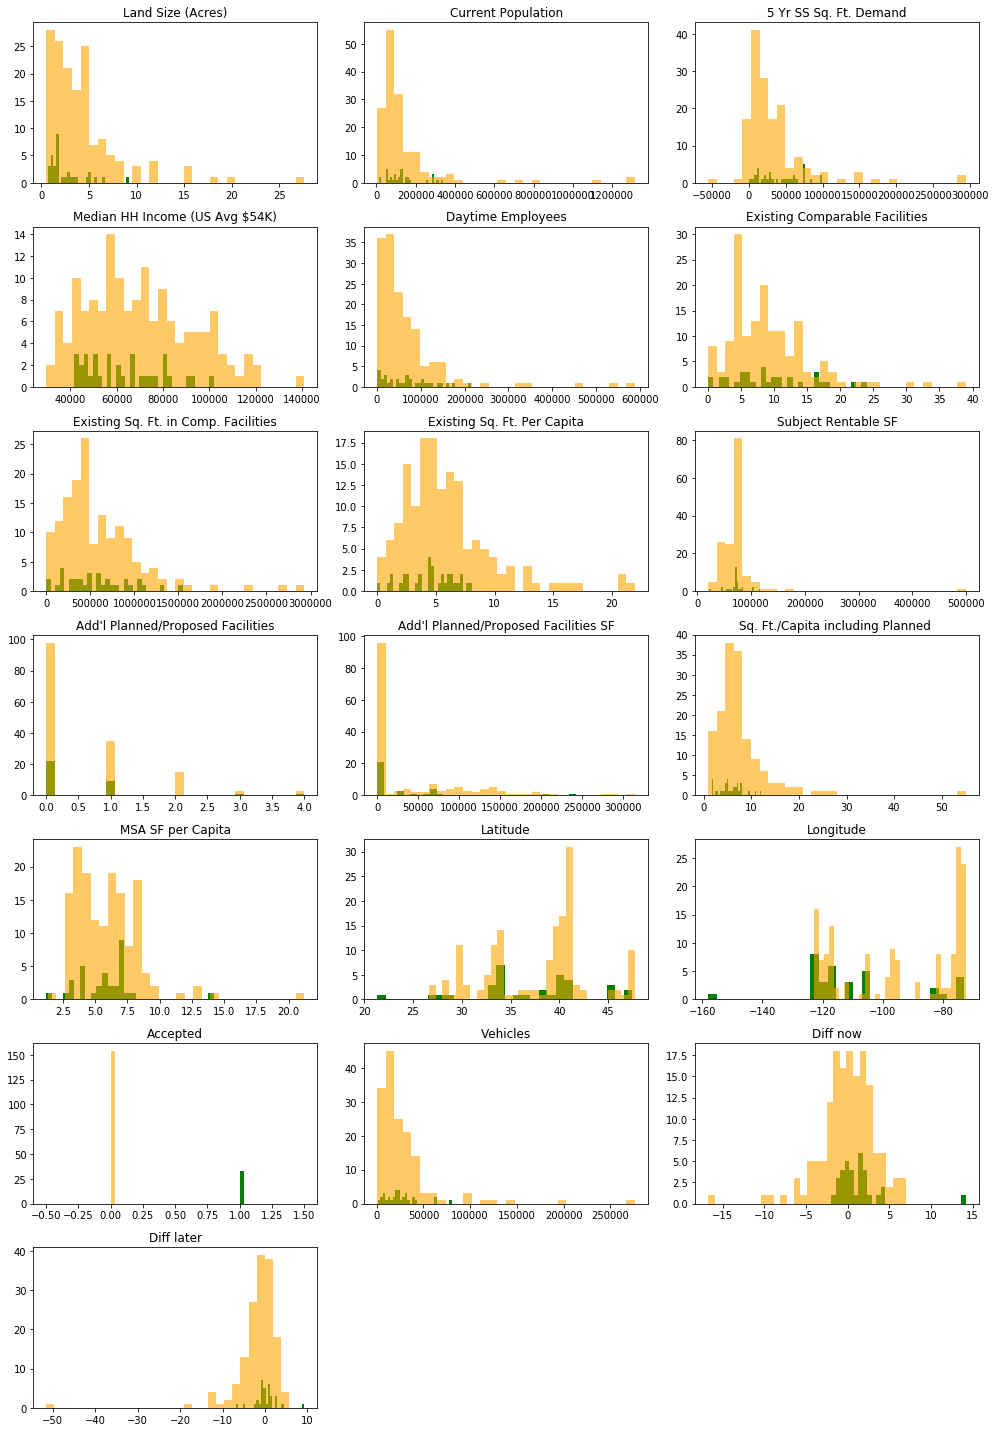

In [28]:
fig = plt.figure(figsize=(14,20))
for c, feature in enumerate(acc.columns, 1):
    ax1 = fig.add_subplot(7,3,c)
    ax1.hist(acc[feature], color='green', bins=30)#, density=True, stacked=True) 
    ax1.hist(rej[feature], color='orange', bins=30, alpha=.6) #, density=True, stacked=True, alpha=.6)
    plt.title(feature)
fig.tight_layout()

Looking at these distributions comparing the accepted (in green) and the rejected (in orange) proposals, nothing obvious sticks out. Hopefully the model will be able to determine a method which project proposals get accepted or rejected.